In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D  # noqa
from matplotlib.colors import hsv_to_rgb
from itertools import chain
import pandas as pd

In [2]:

def fourier_trans(img_,mask):
    img_fft = np.fft.fft2(img_)
    fshift = np.fft.fftshift(img_fft)
    amplitude = 20 * np.log(np.abs(fshift) + 1)
    fshift*=mask
    amplitude_filtered = 20 * np.log(np.abs(fshift) + 1) 
    return np.abs(np.fft.ifft2(np.fft.ifftshift(fshift))),amplitude,amplitude_filtered #np.abs

def plot_fourier(img,amplitude,mask,amplitude_filtered,img_filtered):
    fig, axes = plt.subplots(2,3, figsize=(20, 10))
    fig.delaxes(axes[1,2])
    for img, ax, title in zip([img, amplitude, mask, amplitude_filtered, np.abs(img_filtered)],
                              chain.from_iterable(axes), 
                              ["img", "Amplitude Spectrum", "Filter", "Filtered Amplitude Spectrum", "img filtered"]):
        ax.imshow(img, cmap='gray')
        
def build_circle_mask(radius,channel):
    circle_mask = np.zeros_like(channel)
    rows,cols = channel.shape
    crow,ccol = rows//2,cols//2

    for i in range(crow-radius, crow+radius):
            for j in range(ccol-radius, ccol + radius):
                if (crow - i) ** 2 + (ccol - j) ** 2 <= radius**2:
                    circle_mask[i,j]=1
    return circle_mask

def build_rectangle_low_pass(height,width,channel,center_row=None,center_col=None):
    zeros = np.zeros_like(channel)
    rows,cols = channel.shape
    if center_row is None or center_col is None:
        crow,ccol = rows//2,cols//2
    else:
        crow = center_row
        ccol = center_col
    zeros[crow-height:crow+height,ccol-width:ccol+width] = 1
    return zeros

def build_rectangle_mask(height,width,channel,crow,ccol):
    ones = np.ones_like(channel)
    print(ccol)
    print(ccol+width)
    ones[crow-height//2:crow+height//2,ccol-width//2:ccol+width//2] = 0
    return ones


def mask_fourier(channels,masks):
    filtered_channels = []
    for channel,mask in zip(channels,masks):
        filtered_channel,amplitude,amplitude_filtered = fourier_trans(channel,mask)
        filtered_channels.append(filtered_channel)
        plot_fourier(channel,amplitude,mask,amplitude_filtered,filtered_channel)
    
    return np.dstack([filtered_channels[0].astype(int), 
                       filtered_channels[1].astype(int), 
                       filtered_channels[2].astype(int)])

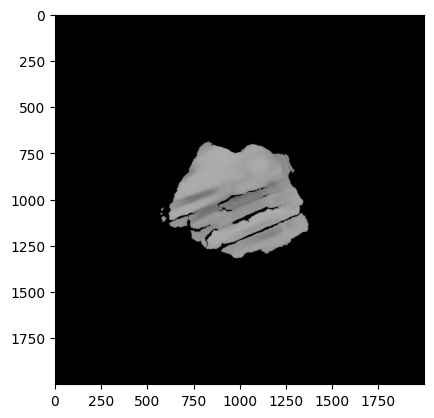

In [3]:
img = cv2.imread('../data/images/RPf_00333_opposite_mesh.png')
img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

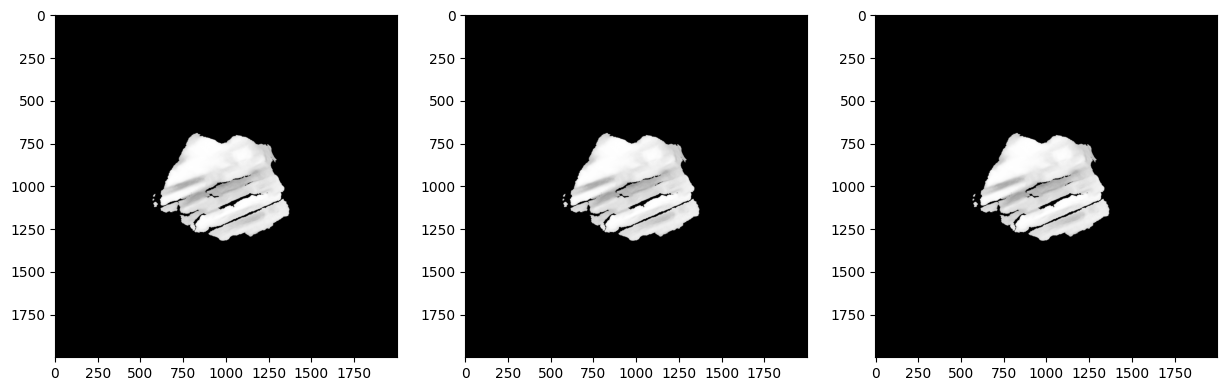

In [5]:
r,g,b = cv2.split(img_rgb)
fig,axes = plt.subplots(1,3,figsize=(15,15))
axes[0].imshow(r,cmap="gray")
axes[1].imshow(g,cmap="gray")
axes[2].imshow(b,cmap="gray")

TypeError: Invalid shape (1, 2000, 6000) for image data

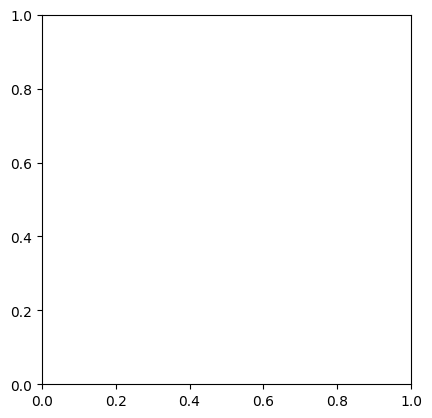

In [6]:
channels= [r,g,b]
filtered_channels = []
for channel in zip(channels):
    img_fft = np.fft.fft2(channel)
    fshift = np.fft.fftshift(img_fft)
    amplitude = 20 * np.log(np.abs(fshift) + 1)
    mask = np.where(amplitude>270,1,0)
    fshift*=mask
    amplitude_filtered = 20 * np.log(np.abs(fshift) + 1) 
    filtered_channel =  np.abs(np.fft.ifft2(np.fft.ifftshift(fshift)))
    filtered_channel,amplitude,amplitude_filtered = fourier_trans(channel,mask)
    filtered_channels.append(filtered_channel)
    #plot_fourier(channel,amplitude,mask,amplitude_filtered,filtered_channel)

new_img = np.dstack([filtered_channels[0].astype(int), 
            filtered_channels[1].astype(int), 
            filtered_channels[2].astype(int)])
plt.imshow(new_img)

In [4]:
img_gray = cv2.cvtColor(img_rgb,cv2.COLOR_RGB2GRAY)
mask = build_rectangle_low_pass(10,10,img_gray)
filtered_channel,amplitude,amplitude_filtered = fourier_trans(img_gray,mask)
filtered_channels.append(filtered_channel)
plot_fourier(img_gray,amplitude,mask,amplitude_filtered,filtered_channel)

NameError: name 'filtered_channels' is not defined

(array([3.400000e+01, 8.240000e+02, 2.387600e+04, 5.953900e+05,
        2.915947e+06, 4.234240e+05, 3.639000e+04, 3.768000e+03,
        3.180000e+02, 2.900000e+01]),
 array([ 21.74363505,  55.06884458,  88.39405412, 121.71926365,
        155.04447318, 188.36968272, 221.69489225, 255.02010179,
        288.34531132, 321.67052086, 354.99573039]),
 <BarContainer object of 10 artists>)

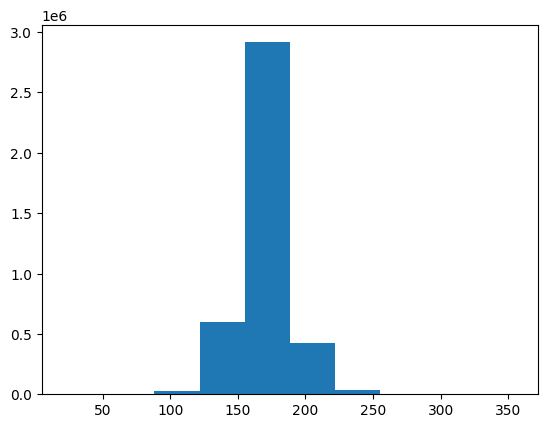

In [8]:
plt.hist(amplitude.reshape(-1,1))

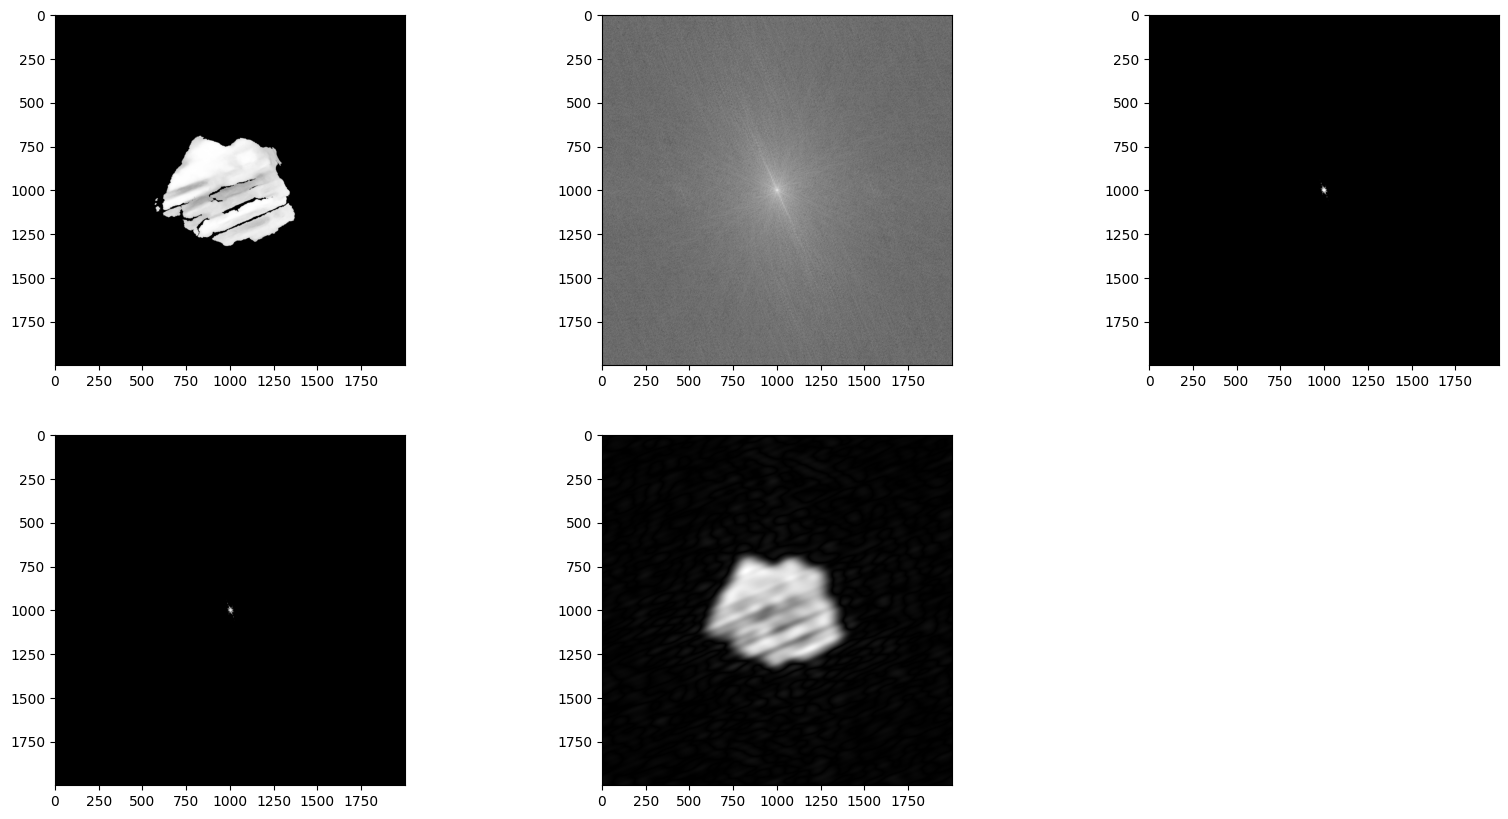

In [37]:
img_fft = np.fft.fft2(img_gray)
fshift = np.fft.fftshift(img_fft)
amplitude = 20 * np.log(np.abs(fshift) + 1)
mask = np.where(amplitude>280,1,0)
fshift*=mask
amplitude_filtered = 20 * np.log(np.abs(fshift) + 1) 
filtered_channel=np.abs(np.fft.ifft2(np.fft.ifftshift(fshift)))
filtered_channel = np.where(filtered_channel<20,0,filtered_channel)
plot_fourier(img_gray,amplitude,mask,amplitude_filtered,filtered_channel)


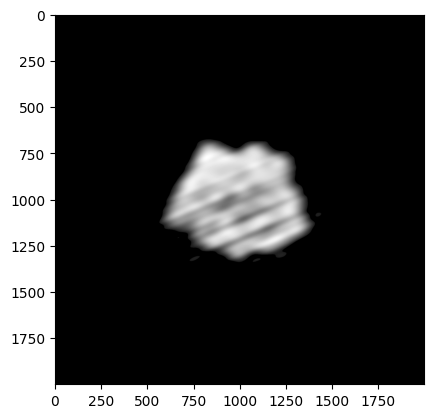

In [39]:
plt.imshow(filtered_channel,cmap="gray")

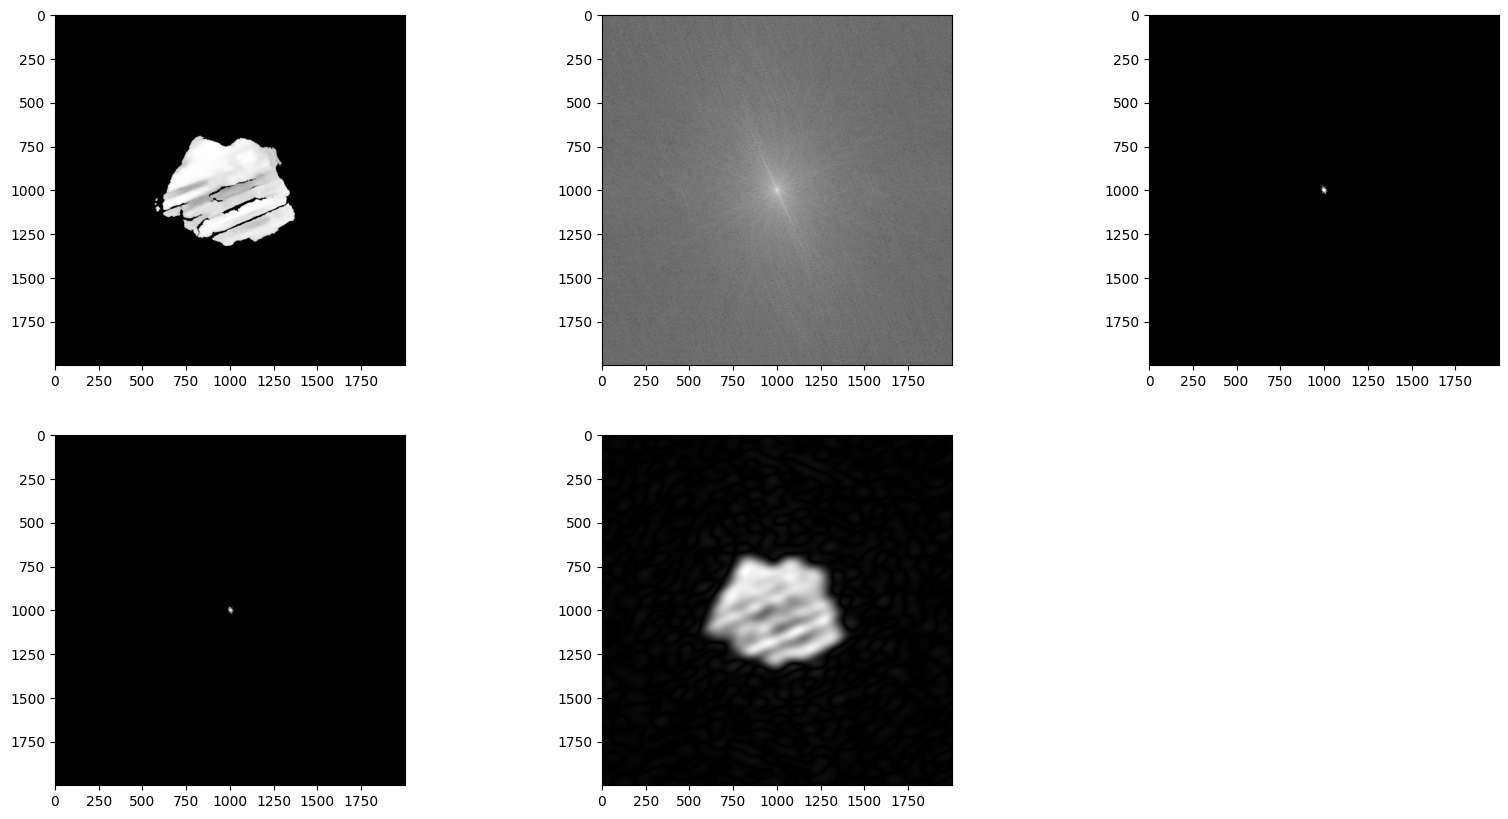

In [31]:
rec_mask = build_rectangle_low_pass(30,40,img_gray)
img_fft = np.fft.fft2(img_gray)
fshift = np.fft.fftshift(img_fft)
amplitude = 20 * np.log(np.abs(fshift) + 1)
mask = np.where(amplitude>280,1,0)
mask *=rec_mask
fshift*=mask
amplitude_filtered = 20 * np.log(np.abs(fshift) + 1) 
filtered_channel=np.abs(np.fft.ifft2(np.fft.ifftshift(fshift)))
plot_fourier(img_gray,amplitude,mask,amplitude_filtered,filtered_channel)


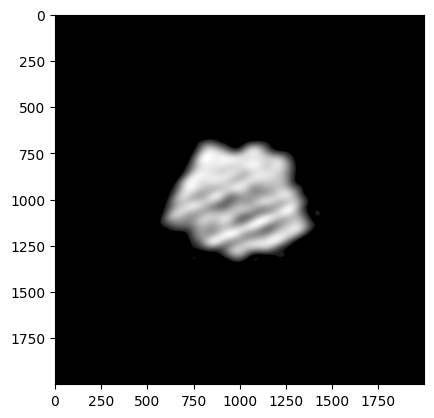

In [33]:
filtered_channel = np.where(filtered_channel<20,0,filtered_channel)
plt.imshow(filtered_channel,cmap="gray")

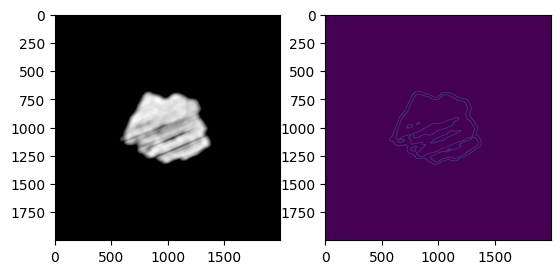

In [79]:
img_fft = np.fft.fft2(img_gray)
fshift = np.fft.fftshift(img_fft)
amplitude = 20 * np.log(np.abs(fshift) + 1)
rows,cols = img_gray.shape
crow,ccol = rows//2,cols//2
mask_rec = build_rectangle_low_pass(50,50,img_gray,center_row=crow+30,center_col=ccol+30)
mask = np.where(amplitude>260,1,0)*2*mask_rec
fshift*=mask
amplitude_filtered = 20 * np.log(np.abs(fshift) + 1) 
filtered_channel=np.abs(np.fft.ifft2(np.fft.ifftshift(fshift)))
filtered_channel = np.where(filtered_channel<60,0,filtered_channel)
#plot_fourier(img_gray,amplitude,mask,amplitude_filtered,filtered_channel)

fig, axs = plt.subplots(1,2)
edge_map = cv2.Canny((filtered_channel).astype(np.uint8)*255,70,210)

axs[0].imshow(filtered_channel,cmap="gray")
axs[1].imshow(edge_map)#,cmap="gray"
plt.show()

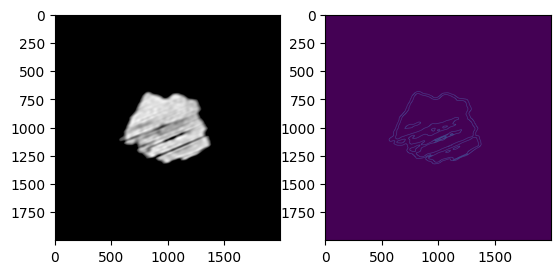

In [80]:
img_fft = np.fft.fft2(img_gray)
fshift = np.fft.fftshift(img_fft)
amplitude = 20 * np.log(np.abs(fshift) + 1)
rows,cols = img_gray.shape
crow,ccol = rows//2,cols//2
mask_rec = build_rectangle_low_pass(100,100,img_gray,center_row=crow+30,center_col=ccol+30)
mask = np.where(amplitude>260,1,0)*2*mask_rec
fshift*=mask
amplitude_filtered = 20 * np.log(np.abs(fshift) + 1) 
filtered_channel=np.abs(np.fft.ifft2(np.fft.ifftshift(fshift)))
filtered_channel = np.where(filtered_channel<60,0,filtered_channel)
#plot_fourier(img_gray,amplitude,mask,amplitude_filtered,filtered_channel)

fig, axs = plt.subplots(1,2)
edge_map = cv2.Canny((filtered_channel).astype(np.uint8)*255,70,210)

axs[0].imshow(filtered_channel,cmap="gray")
axs[1].imshow(edge_map)#,cmap="gray"
plt.show()

np.max(amplitude) 354.995730390255


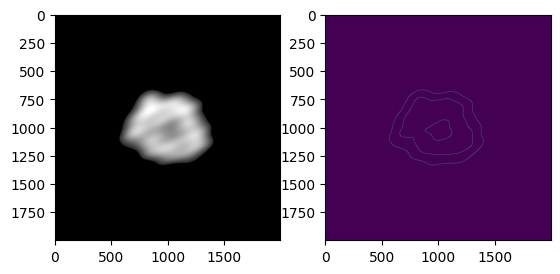

In [88]:
img_fft = np.fft.fft2(img_gray)
fshift = np.fft.fftshift(img_fft)
amplitude = 20 * np.log(np.abs(fshift) + 1)
rows,cols = img_gray.shape
crow,ccol = rows//2,cols//2
mask_rec = build_rectangle_low_pass(100,100,img_gray,center_row=crow+30,center_col=ccol+30)
print ("np.max(amplitude)",np.max(amplitude))
mask =  np.where(amplitude>=np.max(amplitude)-60,1,0)*2*mask_rec
fshift*=mask
amplitude_filtered = 20 * np.log(np.abs(fshift) + 1) 
filtered_channel=np.abs(np.fft.ifft2(np.fft.ifftshift(fshift)))
filtered_channel = np.where(filtered_channel<60,0,filtered_channel)
#plot_fourier(img_gray,amplitude,mask,amplitude_filtered,filtered_channel)

fig, axs = plt.subplots(1,2)
edge_map = cv2.Canny((filtered_channel).astype(np.uint8)*255,70,210)

axs[0].imshow(filtered_channel,cmap="gray")
axs[1].imshow(edge_map)#,cmap="gray"
plt.show()

np.max(amplitude) 354.995730390255
upper_bound 279.995730390255
lower_bound 230


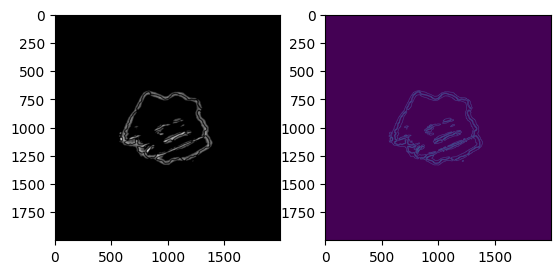

In [97]:
img_fft = np.fft.fft2(img_gray)
fshift = np.fft.fftshift(img_fft)
amplitude = 20 * np.log(np.abs(fshift) + 1)
rows,cols = img_gray.shape
crow,ccol = rows//2,cols//2
mask_rec = build_rectangle_low_pass(100,100,img_gray,center_row=crow+30,center_col=ccol+30)
print ("np.max(amplitude)",np.max(amplitude))
upper_bound = np.max(amplitude)-75
lower_bound = 230
print("upper_bound",upper_bound)
print("lower_bound",lower_bound)
mask =  np.where((amplitude <= upper_bound) & (amplitude>=lower_bound),1,0)*2*mask_rec
fshift*=mask
amplitude_filtered = 20 * np.log(np.abs(fshift) + 1) 
filtered_channel=np.abs(np.fft.ifft2(np.fft.ifftshift(fshift)))
filtered_channel = np.where(filtered_channel<60,0,filtered_channel)
#plot_fourier(img_gray,amplitude,mask,amplitude_filtered,filtered_channel)

fig, axs = plt.subplots(1,2)
edge_map = cv2.Canny((filtered_channel).astype(np.uint8)*255,70,210)

axs[0].imshow(filtered_channel,cmap="gray")
axs[1].imshow(edge_map)#,cmap="gray"
plt.show()

upper_bound 279.995730390255
lower_bound 230


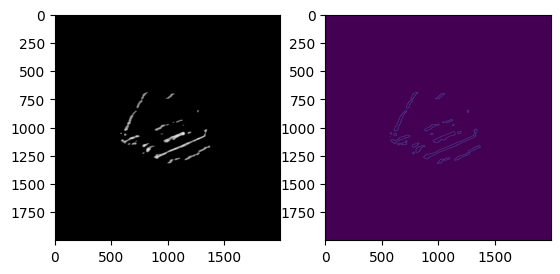

In [139]:
img_fft = np.fft.fft2(img_gray)
fshift = np.fft.fftshift(img_fft)
amplitude = 20 * np.log(np.abs(fshift) + 1)
rows,cols = img_gray.shape
crow,ccol = rows//2,cols//2
mask_rec = build_rectangle_low_pass(100,100,img_gray,center_row=crow+100,center_col=ccol+100)
upper_bound = np.max(amplitude)-75
lower_bound = 230
print("upper_bound",upper_bound)
print("lower_bound",lower_bound)
mask =  np.where((amplitude <= upper_bound) & (amplitude>=lower_bound),1,0)*2*mask_rec
fshift*=mask
amplitude_filtered = 20 * np.log(np.abs(fshift) + 1) 
filtered_channel=np.abs(np.fft.ifft2(np.fft.ifftshift(fshift)))
filtered_channel = np.where(filtered_channel<60,0,filtered_channel)
#plot_fourier(img_gray,amplitude,mask,amplitude_filtered,filtered_channel)

fig, axs = plt.subplots(1,2)
edge_map = cv2.Canny((filtered_channel).astype(np.uint8)*255,70,210)

axs[0].imshow(filtered_channel,cmap="gray")
axs[1].imshow(edge_map)#,cmap="gray"
plt.show()

upper_bound 254.995730390255
lower_bound 230


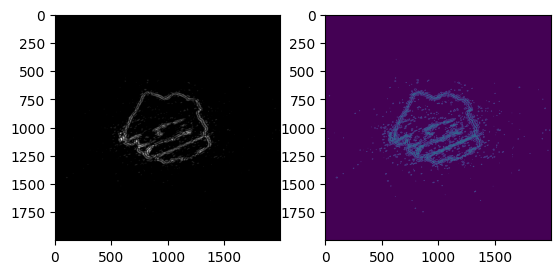

In [158]:
img_fft = np.fft.fft2(img_gray)
fshift = np.fft.fftshift(img_fft)
amplitude = 20 * np.log(np.abs(fshift) + 1)
rows,cols = img_gray.shape
crow,ccol = rows//2,cols//2
mask_rec = build_rectangle_low_pass(500,500,img_gray,center_row=crow,center_col=ccol)
upper_bound = np.max(amplitude)-100
lower_bound = 230
print("upper_bound",upper_bound)
print("lower_bound",lower_bound)
mask =  np.where((amplitude <= upper_bound) & (amplitude>=lower_bound),1,0)*5*mask_rec
fshift*=mask
amplitude_filtered = 20 * np.log(np.abs(fshift) + 1) 
filtered_channel=np.abs(np.fft.ifft2(np.fft.ifftshift(fshift)))
filtered_channel = np.where(filtered_channel<60,0,filtered_channel)
#plot_fourier(img_gray,amplitude,mask,amplitude_filtered,filtered_channel)

fig, axs = plt.subplots(1,2)
edge_map = cv2.Canny((filtered_channel).astype(np.uint8)*255,70,210)

axs[0].imshow(filtered_channel,cmap="gray")
axs[1].imshow(edge_map)#,cmap="gray"
plt.show()

In [159]:
cv2.imwrite("../data/images/RPf_00333_opposite_filtered.png",filtered_channel)

True